# Quantum Phase Estimation for Solving Matrix Eigenvalues

Quantum Phase Estimation (QPE) is a key algorithm in quantum computing, allowing you to estimate the phase (or eigenvalue) relating to a Hermitian matrix. The algorithm is designed such that given the inputs of a matrix $M$ and an eigenvalue ${|\psi\rangle}$, the output obtained is $\theta$, where

$ U{|\psi\rangle} = e^{2\pi i\theta}{|\psi\rangle} , U = e^{2\pi iM} $.

By measuring the accumulated phase, the QPE algorithm calculates the eigenvalues relating to the chosen input vector. To read more about the QPE algorithm and its method for achieving the phase, refer to [[1](#NC)].

Generally speaking, when the eigenvectors of the matrix are not known in advance yet the eigenvalues are sought, you can choose a random vector ${|v\rangle}$ for the algorithm’s initial state. Some eigenvalues will be found as the vector can be described in the matrix's basis, defined by the set of eigenvalues of $M$: {$\psi_i$}. Generally, any vector can be written as a superposition of any basis set, thus

${|v\rangle} = \sum_i a_i{|\psi_i\rangle}$

and

$U{|v\rangle} = \sum_i a_i e^{2\pi i\theta_i}{|\psi_i\rangle}$.

Using execution with enough shots, you can obtain this set of $\theta_i$; i.e., a subset of the matrix's eigenvalues.

**This tutorial presents a generic usage of the QPE algorithm:**

1. Define a matrix.

2. Initialize a state either with its eigenstate or with a random vector.

3. Choose a resolution for the solution.

4. Find the related eigenvalues using QPE and analyze the results.

## Prerequisites

This tutorial uses external libraries.

In [2]:
import itertools  # noqa
import math
from itertools import product
from typing import List, cast

import numpy as np
from numpy import kron, linalg as LA

from classiq import *

## 1. Setting a Specific Example

### 1.1. Set the Matrix

Define the matrix to submit. This can be any Hermitian matrix with size $2^n$ by $2^n$ with $n$ a positive integer. Throughout the code this matrix is given in the variable `M`.

In [3]:
M = np.array([[0, 3, 4, 0], [-0.8, 3, 0, 0], [1, 0, -0.5, 5], [0, 0, 0, -0.75]])

M = np.array(
    [
        [0.38891555, 0.23315811, 0.21499372, 0.06119557],
        [0.23315811, 0.44435328, 0.25197881, -0.13087919],
        [0.21499372, 0.25197881, 0.44116509, -0.01961855],
        [0.06119557, -0.13087919, -0.01961855, 0.32556608],
    ]
)

M = (M + M.transpose()) / 2

### 1.2. Set the Initial Vector 

Choose the vector that will be defined later as the initial condition for the run. There are two options:
1. Define your own initial vector in the variable `int_vec`, while setting the parameter `eigen_vec` as `False`.
2. Set `eigen_vec` to `True`, then you can choose the index `ev` of the eigenvalue that will be set as the initial state.

In [4]:
eigen_vec = False
ev = 1

if eigen_vec:
    w, v = LA.eig(M)
    print("the eigenvalues are", w)
    print("the eigenvectors are", v, sep="\n")
    int_vec = v[:, ev]
else:
    int_vec = np.random.rand(np.shape(M)[0])

print("Your initial state is", int_vec)

Your initial state is [0.91849887 0.03424616 0.50686831 0.88997823]


## 2. Constructing Auxiliary Functions

Defining some auxiliary functions is essential for designing the QPE in a modular fashion.

### 2.1 Classical Functions

#### 2.1.1 Matrix Rescaling

As QPE obtains a phase in the form $e^{2\pi i\theta}$, there is meaning only for $\theta \in [0,1)$. However, the matrix M can have any eigenvalue. To fix this discrepancy, the values of the matrix stretch to be rescaled. If
$\theta \in [\lambda_{min}, \lambda_{max}]$ you can use a normalization function to map those values into $[0, 1-1/{2^m}]$, where $m$ 
is the size of the QPE register.

Perform the normalization procedure by:

a. Defining the function `normalization_params()` that finds a rough estimation for the eigenvalue with the largest absolute value by adding together all the Pauli coefficients and multiplying by the matrix's dimensions. This yields a value $\lambda$ (which is referred to in the code as `normalization_coeff`) and now you can assume that the domain is $\theta \in [-\lambda, \lambda]$.
In general, you can build a more accurate assessment that decreases the span of solutions and thus achieves a better resolution.

In [5]:
def normalization_params(hamiltonian):
    return len(hamiltonian[0].pauli) * sum(
        [abs(hamiltonian[k].coefficient) for k in range(len(hamiltonian))]
    )

b. Defining the function `normalize_hamiltonian` that shifts the matrix by adding $\lambda*I^n$ to the Pauli list. (The evaluated span is thus $\theta\in[0, 2*\lambda]$) and normalizes it by multiplying all the Pauli coefficients by $(1-1/2^n)/(2*\lambda)$ (the evaluated span is then $\theta\in [0, 1-1/2^n]$, as required.)

In [6]:
def normalize_hamiltonian(hamiltonian, normalization_coeff, k):
    list_size = len(hamiltonian)
    num_qubits = len(hamiltonian[0].pauli)
    normalization = (1 - 1 / (2**k)) / (2 * normalization_coeff)
    normalized_list = [
        PauliTerm(
            pauli=hamiltonian[k].pauli,
            coefficient=hamiltonian[k].coefficient * normalization,
        )
        for k in range(list_size)
    ]
    if [Pauli.I] * num_qubits in [hamiltonian[k].pauli for k in range(list_size)]:
        id_index = [y.pauli for y in hamiltonian].index([Pauli.I] * num_qubits)
        normalized_list[id_index] = PauliTerm(
            pauli=[Pauli.I] * num_qubits,
            coefficient=(hamiltonian[id_index].coefficient + normalization_coeff)
            * normalization,
        )
    else:
        normalized_list.append(
            PauliTerm(
                pauli=[Pauli.I] * num_qubits,
                coefficient=normalization_coeff * normalization,
            )
        )

    return normalized_list

#### 2.1.2 QPE Precision Estimator

For QPE algorithms, the precision is set by phase register size $m$, such that the resolution is $1/{2^m}$. If the matrix needs to be normalized, the resolution will be distorted. In the case of normalization, the span of results for the QPE stretches between the lowest and highest possible phase, thus the resolution is mapped to $normalization-coefficient/{2^m} ~\sim 1/{((\lambda_{max}-\lambda_{min})*2^m)}$.

In [7]:
def get_qpe_precision(hamiltonian, desired_resolution):
    nqpe = math.log2(2 * normalization_params(hamiltonian) / desired_resolution)
    return math.ceil(nqpe)

### 2.2 Quantum Functions

Use the built-in `qpe_flexible` function, which allows you to prescribe the "telescopic" expansion of the powered unitary via the `unitary_with_power` "QCallable" (see [Flexible QPE tutorial](https://docs.classiq.io/latest/tutorials/tutorials/high-level-modeling-flexible-qpe/high-level-modeling-flexible-qpe/ )). Define two examples for the powered unitary:


#### 2.2.1 A First Order Suzuki Trotter with power-logic

Wrap the Trotter-Suzuki function of order 1 with a "power-logic" for the repetition as a function of its power.

In [8]:
from classiq.qmod.symbolic import ceiling, log


@qfunc
def suzuki_trotter1_with_power_logic(
    hamiltonian: CArray[PauliTerm],
    pw: CInt,
    r0: CInt,
    reps_scaling_factor: CReal,
    evolution_coefficient: CReal,
    target: QArray[QBit],
) -> None:
    suzuki_trotter(
        hamiltonian,
        evolution_coefficient=evolution_coefficient * pw,
        order=1,
        repetitions=r0 * ceiling(reps_scaling_factor ** (log(pw, 2))),
        qbv=target,
    )

#### 2.2.2 A Unitary with power-logic

As an alternative to the Trotter-Suzuki formula, you can work with an exact unitary decomposition. In this case, the power-logic is naive:

In [9]:
@qfunc
def unitary_with_power_logic(
    pw: CInt, matrix: CArray[CArray[CReal]], target: QArray[QBit]
) -> None:
    power(pw, lambda: unitary(elements=matrix, target=target))

## 3. Preparing the Matrix for QPE

In [10]:
hamiltonian = matrix_to_hamiltonian(M)

In [11]:
N = len(hamiltonian[0].pauli)
print("number of qubits: ", N)

number of qubits:  2


### 3.1 Choose the Algorithm's Precision

Choose the precision using the `n_qpe` parameter or set your desired resolution. If you choose the resolution and set the parameter `get_recommended_qpe_size` parameter to True, the number of qubits is calculated for you accordingly.

In [12]:
n_qpe = 8

# recommended QPE_SIZE:
get_recommended_qpe_size = False

desired_resolution = 0.02


if get_recommended_qpe_size:
    n_qpe = get_qpe_precision(hamiltonian, desired_resolution)

print("number of qubits for QPE is", n_qpe)

number of qubits for QPE is 8


### 3.2 Normalize the Matrix

Transform the matrix to ensure its eigenvalues are between $0$ to $1-(1/2^m)$. The QPE procedure is performed on the new normalized matrix. After the phases are obtained, gather the original phases of the pre-normalized matrix by performing opposite steps to this normalization procedure.

* If the matrix eigenvalues are naturally between the values $0$ to $1-(1/2^n)$, you may not want to normalize them as that  may enlarge the span, thus lowering the resolution of the algorithm. In this case, skip those lines or change the value of `normalize` to False.

In [13]:
# normalizing the operator
## create a matrix such that its normalized version has eigenvalues of [0,1/2^k] where k is the resolution of the QPE
normalize = True
if normalize:
    normalization_coeff = normalization_params(hamiltonian)
    new_hamiltonian = normalize_hamiltonian(hamiltonian, normalization_coeff, n_qpe)
    print(new_hamiltonian)

    size = math.sqrt(M.size)
    I = np.eye(int(size))

    Mnew = (
        (M + normalization_coeff * I) * (1 - 1 / (2**n_qpe)) / (2 * normalization_coeff)
    )

else:
    Mnew = M

[PauliTerm(pauli=[<Pauli.I: 0>, <Pauli.I: 0>], coefficient=0.582852238955473), PauliTerm(pauli=[<Pauli.I: 0>, <Pauli.Z: 3>], coefficient=0.003188749529016948), PauliTerm(pauli=[<Pauli.Z: 3>, <Pauli.I: 0>], coefficient=0.0035267190456534513), PauliTerm(pauli=[<Pauli.Z: 3>, <Pauli.Z: 3>], coefficient=-0.009065520615911005), PauliTerm(pauli=[<Pauli.I: 0>, <Pauli.X: 1>], coefficient=0.02263662513086446), PauliTerm(pauli=[<Pauli.Z: 3>, <Pauli.X: 1>], coefficient=0.026796020813436065), PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.I: 0>], coefficient=0.00891670416324194), PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.Z: 3>], coefficient=0.036664847518610696), PauliTerm(pauli=[<Pauli.X: 1>, <Pauli.X: 1>], coefficient=0.033198584096787005), PauliTerm(pauli=[<Pauli.Y: 2>, <Pauli.Y: 2>], coefficient=0.020224302631005442)]


## 4. Building the Quantum Model

Create a quantum model of the QPE algorithm using the Classiq platform with your desired constraints and preferences.

There are generally two methods for inserting the matrix into the QFT: unitary implementation, which is exact but long; and exponentiation, which is approximated but shorter in depth. Choose the parameter `IS_EXACT` to indicate the chosen method.

In [14]:
import scipy

IS_EXACT = True

my_amp = (
    int_vec / np.linalg.norm(int_vec)
).tolist()  # amplitude is given by the eignevector


@qfunc
def main(phase_result: Output[QNum[n_qpe, False, n_qpe]]) -> None:
    state = QArray("state")
    prepare_amplitudes(my_amp, 0.0, state)
    allocate_num(n_qpe, False, n_qpe, phase_result)
    qpe_flexible(
        unitary_with_power=lambda pw: if_(
            condition=IS_EXACT,
            then=lambda: unitary_with_power_logic(
                matrix=scipy.linalg.expm(1j * 2 * np.pi * Mnew).tolist(),
                pw=pw,
                target=state,
            ),
            else_=lambda: suzuki_trotter1_with_power_logic(
                hamiltonian=hamiltonian,
                pw=pw,
                r0=2,
                reps_scaling_factor=1.8,
                evolution_coefficient=-2 * np.pi,
                target=state,
            ),
        ),
        phase=phase_result,
    )


qmod = create_model(main)
num_shots = 10000
qmod = update_execution_preferences(qmod, num_shots=num_shots)
write_qmod(qmod, "qpe_for_matrix", decimal_precision=15)

Synthesize the circuit and display it with the analyzer.

In [17]:
qprog = synthesize(qmod)
show(qprog)

# 5. Measuring and Analyzing the Generated Circuit 

Execute the circuit and analyze the results obtained from the quantum program, in comparison to the expected classical ones.

### 5.1. Run the Circuit 

Send the circuit for execution by a chosen backend.

In [18]:
result = execute(qprog).result_value()

Choose the number of eigenvalues to extract from the poll of results. The `number_of_solutions` value determines how many results from `qpe_results` are analyzed.

In [20]:
number_of_solutions = 2  # number of phases sought

### 5.2. Translate into Eigenvalues (Phases)

Here, the value in the `results` vector is translated from a binary number into a full solution for the eigenvalues.

Initially, use the parsed results to obtain the phases of the normalized matrix.

In [21]:
dec_sol_vec = [
    sampled_state.state["phase_result"]
    for sampled_state in result.parsed_counts[:number_of_solutions]
]

print("Your decimal solutions are", dec_sol_vec, sep="\n")

Your decimal solutions are
[0.58203125, 0.6875]


Then these decimal values are mapped back into the original values; i.e., renormalized into the original span.

In [22]:
# renormalize into the "real" solution -
if normalize:
    solution = [
        ((value * 2 * normalization_coeff / (1 - (1 / 2**n_qpe))) - normalization_coeff)
        for value in dec_sol_vec
    ]
else:
    solution = dec_sol_vec

These are the results of the phases (matrix eigenvalues):

In [23]:
print(solution)

[0.39612765552941154, 0.8935902927058823]


These are the results, including the error contributed from the resolution (the number of qubits participating in the QPE):

In [24]:
if normalize:
    energy_resolution = (
        (1 / (2**n_qpe)) * 2 * normalization_coeff / (1 - (1 / 2**n_qpe))
    )
else:
    energy_resolution = 1 / (2**n_qpe)

print("the resolution of results is", energy_resolution)

for sol in solution:
    print(
        "the solutions are between",
        sol - energy_resolution,
        "and",
        sol + energy_resolution,
    )

    ### if zero or exceeds the normalization range, need to add conditions

the resolution of results is 0.018424542117647057
the solutions are between 0.3777031134117645 and 0.4145521976470586
the solutions are between 0.8751657505882352 and 0.9120148348235294


### 5.3. Compare to Exact Results

In [25]:
w, v = LA.eig(M)

print("the eigenvalues are", w)
print("the eigenvectors are", v, sep="\n")

the eigenvalues are [0.9 0.4 0.1 0.2]
the eigenvectors are
[[ 0.51510515  0.41480695  0.5588446  -0.50029451]
 [ 0.61747259 -0.30596016 -0.64233734 -0.3354381 ]
 [ 0.58498122  0.11134965  0.09256217  0.79801659]
 [-0.10578874  0.8496616  -0.51626321  0.01887348]]


### 5.4. Find the Solution's Histogram

In [26]:
import matplotlib.pyplot as plt
import numpy as np

energy_vec = []
energy_prob = []

for sampled_state in result.parsed_counts:
    temp = sampled_state.state["phase_result"]
    if normalize:
        temp2 = (
            temp * 2 * normalization_coeff / (1 - (1 / 2**n_qpe))
        ) - normalization_coeff
    else:
        temp2 = temp
    energy_vec.append(temp2)
    energy_prob.append(sampled_state.shots / num_shots)

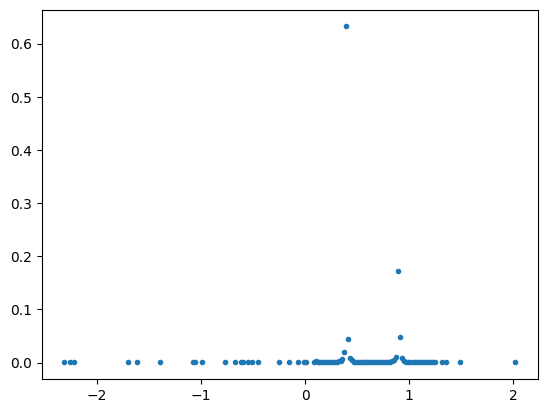

In [27]:
plt.plot(energy_vec, energy_prob, ".")
plt.show()

## References

<a name='NC'>[1]</a>: [Michael A. Nielsen and Isaac L. Chuang. 2011. Quantum Computation and Quantum Information: 10th Anniversary Edition, Cambridge University Press, New York, NY, USA.
](https://archive.org/details/QuantumComputationAndQuantumInformation10thAnniversaryEdition)
